# Final Pipeline

This is my final pipeline for the Compartmental model part of the Hubs project. It is designed to be as straightforward as possible, however please contact me if you have questions.

C Zachary Zanussi, July 31st, 2020. Statistics Canada

Run the definitions below and we'll meet up at the 'Pipeline' section. Go to the end of the file for an explanation of the process, model, etc.

In [ ]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import csv

import matplotlib.dates as mdates
from datetime import date, timedelta
import lmfit 
from scipy.integrate import odeint


from pyDOE import *

## Functions and definitions

In [ ]:
data_prefix = '../data/'

def get_HR_name(HR_UID):
    conn = sql.connect(data_prefix + 'hubs.db')
    cursor = conn.cursor()
    
    cursor.execute('SELECT ENGNAME FROM HR WHERE HR_UID = ' + str(HR_UID))
    rows = cursor.fetchall()
    if len(rows) == 0:
        print("No HR with that UID")
        return None
    
    return rows[0][0]

# Use to get data from the Covid19 table.A 
#    columns : a string of column names from the Covid19 table, must be separated by ', '. Eg 'dates, cases'
#    HR_UID : a four digit HR ID, as an int or string. Ottawa is 3551
def get_HR_data(columns, HR_UID):
    conn = sql.connect(data_prefix + 'hubs.db')
    cursor = conn.cursor()

    cursor.execute('SELECT ' + columns + ' FROM Covid19 WHERE HR_UID = ' + str(HR_UID))
    results = pd.DataFrame(cursor.fetchall())
    results.columns = columns.split(', ')
    #print(results[:5])
    cursor.close()
    conn.close()
    
    return results

# Use to get all the health indicators for a health region from the Health_Indicators_ODHF table as a dictionary. 
#    HR_UID : a four digit HR ID, as an int or string. Ottawa is 3551
def get_HR_dict(HR_UID):
    conn = sql.connect(data_prefix + 'hubs.db')
    cursor = conn.cursor()

    cursor.execute('SELECT * FROM Health_Indicators_ODHF WHERE HR_UID == ' + str(HR_UID))
    tuples = cursor.fetchall()
    if len(tuples) == 0:
        print("No HR with that UID")
        return None

    results = [tuples[0][y] for y in range(len(tuples[0]) - 1)]
    keys = [cursor.description[y][0] for y in range(len(cursor.description) - 1)]

    hr_dict = {}
    for key in zip(keys,results):
        hr_dict[key[0]] = key[1]

    return hr_dict

# Plot the data returned by get_HR_data. 
#    df : a dataframe of the from returned by get_HR_data
#    column : name of column (or columns) to plot. If None, then plots all columns. Should be a string of the same form as in get_HR_data
#    hr_name : name of the HR plotted, as a string. Prints the name of the HR in the title.
def plot_frame(df, column = None, hr_name = None):
    months = mdates.MonthLocator()
    days = mdates.DayLocator()
    years_fmt = mdates.DateFormatter("%Y-%m-%d") # Sets the output format for dates on axis

    # Set up the plot
    fig, ax = plt.subplots(figsize = (19,10))
    dates = df['report_date'].apply(lambda x : np.datetime64(x))
    if column == None:
        column = list(df.columns[1:])
    else:
        column = column.split(', ')
    for col in column:
        ax.scatter(dates, df[col])

    # Set the axis
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(days)

    # Set the axis ranges
    datemin = dates[0]
    datemax = dates[len(dates) - 1]
    ax.set_xlim(datemin, datemax)

    # More axis stuff
    ax.format_xdata = mdates.DateFormatter("%m-%d")
    ax.grid(True)
    fig.autofmt_xdate()
    
    plt.title("Data about " + ", ".join(column) + " by day" + ("" if hr_name == None else ' in ' + hr_name), fontdict = {'fontsize': 20} )
    plt.legend(column, fontsize = 15)

    return fig, ax, plt

In [ ]:
def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start - R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def deriv(y, t, beta, tau1, tau2, delta, epsilon, rho, alpha, gamma, N):
    S, E, IU, CI, D, R = y # y wraps up all the compartments
    
    
    dSdt = - S * (tau1 * IU + tau2 * CI) * beta(t) / N
    dEdt = S * (tau1 * IU + tau2 * CI) * beta(t) / N - delta * E
    dIUdt = delta * E - epsilon * IU - rho * alpha * IU - gamma * (1 - alpha) * IU
    dCIdt = epsilon * IU - rho * alpha * CI - gamma * (1 - alpha) * CI
    dDdt = rho * alpha * (IU + CI)
    dRdt = gamma * (1 - alpha) * (IU + CI)
    
    return dSdt, dEdt, dIUdt, dCIdt, dDdt, dRdt

def Model(days, N, R_0_start, k, x0, R_0_end, tau1, tau2, delta, epsilon, rho, gamma, alpha):
    
    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma
    
    y0 = N - 20.0, 10.0, 10.0, 0.0, 0.0, 0.0 # Initial population; just one exposed person
    
    t = np.linspace(0, days - 1, int(days))
    ret = odeint(deriv, y0, t, args=(beta, tau1, tau2, delta, epsilon, rho, alpha, gamma, N))
    S, E, IU, CI, D, R = ret.T
    
    # this is R_0 throughout for plotting
    R_0_over_time = [beta(i) / gamma for i in range(len(t))]
    beta_over_time = [beta(i) for i in range(len(t))]
    
    return t, S, E, IU, CI, D, R, R_0_over_time, beta_over_time

# def Model(days, N, model):
#     R_0_start, k, x0, R_0_end = model.best_values.values()
#     return Model(days, N, R_0_start, k, x0, R_0_end)

def plotting(t, S, E, IU, CI, D, R, R_0_over_time, beta_over_time, x_ticks = None, x0 = None):
    f,ax = plt.subplots(1,1,figsize=(15,4))
    ax.title.set_text("SEIDR Model")
    
####!=
    if x_ticks is not None:
        months = mdates.MonthLocator()
        days = mdates.DayLocator()
        years_fmt = mdates.DateFormatter("%Y-%m-%d") # Sets the output format for dates on axis

        # Set up the plot
        dates = x_ticks.apply(lambda x : np.datetime64(x))

        # Set the axis
        ax.xaxis.set_major_locator(months)
        ax.xaxis.set_major_formatter(years_fmt)
        ax.xaxis.set_minor_locator(days)

        # Set the axis ranges
        datemin = dates[0]
        datemax = datemin + timedelta(days=len(t) - 1)
        ax.set_xlim(datemin, datemax)

        ax.format_xdata = mdates.DateFormatter("%m-%d")
        #ax.grid(True)
        f.autofmt_xdate()
        
        t = pd.date_range(start = datemin, end = datemax)
####
    def annihilate_small_values(compartment):
        return [compartment[i] if compartment[i] >=1 else 1 for i in range(len(compartment))]

    #ax.plot(t, annihilate_small_values(S), 'b', alpha = 0.7, linewidth = 2, label='Susceptible')
    ax.plot(t, annihilate_small_values(E), 'y', alpha = 0.7, linewidth = 2, label='Exposed')
    ax.plot(t, annihilate_small_values(IU), ':r', alpha = 0.7, linewidth = 2, label='Infected Undetected')
    ax.plot(t, annihilate_small_values(CI), '--r', alpha = 0.7, linewidth = 2, label='Confirmed Infected')
    ax.plot(t, annihilate_small_values(IU + CI), 'r', alpha = 0.7, linewidth = 2, label='Total Infected')
    ax.plot(t, annihilate_small_values(D), 'k', alpha = 0.7, linewidth = 2, label='Dead')
    ax.plot(t, annihilate_small_values(R), 'g', alpha = 0.7, linewidth = 2, label='Recovered')
    #ax.set_yscale('log')

    
    ax.grid(b = False, which = 'minor',c='w', lw = 2, ls = '-')
    
    
    
    
    for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)


    #plt.show()

    f = plt.figure(figsize = (15,4))
    # Plot of R_0 over time
    ax1 = f.add_subplot(131)
    ax1.plot(t, R_0_over_time, alpha = 0.7, linewidth=2, label='R_0')
    ax1.title.set_text('Daily R_0 value')
    
    for spine in ('top','right','bottom','left'):
        ax1.spines[spine].set_visible(False)
    
    # Plot of total infected death rate. Calculated as total deaths divided by everyone who's been infected up to that point.
    # Denominator is calculated as delta * sum(E[:t]), because that is all the people added to the I compartment.
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(delta * E[:i]) if sum(delta * E[:i]) > 0 else 0 for i in range(1, len(t))]
    ax2.plot(t, total_CFR, alpha = 0.7, linewidth = 2, label = 'Death Rate among Infected')
    
    ax2.title.set_text("Death Rate %")
    for spine in ('top', 'right', 'bottom', 'left'):
            ax2.spines[spine].set_visible(False)

    # Plot of deaths per day.
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i] - D[i - 1] for i in range(1, len(t))]
    ax3.plot(t, newDs, alpha = 0.7, linewidth=2, label="Daily Deaths")
    ax3.title.set_text("Deaths Per Day")
    for spine in ('top', 'right', 'bottom', 'left'):
            ax3.spines[spine].set_visible(False)
        
    f.autofmt_xdate()
    
    if x0 is not None:
        if x_ticks is not None:
            x0 = datemin + timedelta(days=x0 - 1)
        ax.axvline(x = x0, color = 'r', label = 'x0', linestyle = '--')
        ax1.axvline(x = x0, color = 'r', label = 'x0', linestyle = '--')
        ax2.axvline(x = x0, color = 'r', label = 'x0', linestyle = '--')
        ax3.axvline(x = x0, color = 'r', label = 'x0', linestyle = '--')
        
    ax.legend()
    ax1.legend()
    ax2.legend()
    ax3.legend()
    
    plt.show()
    
def fitter(x, days, N, R_0_start, k, x0, R_0_end, tau1, tau2, delta, epsilon, rho, gamma, alpha):
    ret = Model(len(x), N, R_0_start, k, x0, R_0_end, tau1, tau2, delta, epsilon, rho, gamma, alpha)
    #new_inf = ret[2] * delta
    confirmed_cases = ret[3] * epsilon
    cum_cases = [np.sum(confirmed_cases[:i]) for i in range(len(confirmed_cases))]
    
    return np.concatenate([cum_cases, ret[5][x]]) # return the xth value of Deaths, which is 4 in the return list of Model

def fit_SEIDR_model(HR_UID, days_to_ignore_front = None, days_to_ignore_back = None, param_dict = None, normalized = False):
    
    if normalized == False:
        N, x_dat, cases, deaths, dates = get_some_data(HR_UID, days_to_ignore_front)
    else:
        N, x_dat, cases, deaths, dates = get_some_data_normalized(HR_UID, days_to_ignore_front)
        
    if days_to_ignore_back is not None:
        deaths = deaths[:-days_to_ignore_back]
        cases = cases[:-days_to_ignore_back]
        x_dat = x_dat[:-days_to_ignore_back]
        dates = dates[:-days_to_ignore_back]
        
    days = len(deaths)
    data = np.array([cases, deaths]).flatten()
    mod = lmfit.Model(fitter)
    
    
    for kwarg, (vary, init, mini, maxi) in param_dict.items():
        if vary == True:
            mod.set_param_hint(str(kwarg), value = init, min = mini, max = maxi, vary = True)
        else: 
            mod.set_param_hint(str(kwarg), value = init, vary = False)
    
    
    mod.set_param_hint("days",value = days, vary = False)
    mod.set_param_hint("N", value = N, vary = False)
    
    params = mod.make_params()
    fit_method = 'leastsq'
    #emcee_kws = dict(steps=1000, burn=300, thin=20, is_weighted=False,
                 #progress=False)
        
    result = mod.fit(data, params, method = fit_method, x = x_dat)
    return result

def get_some_data(HR_UID, forget_first_days = None):
    hr_dict = get_HR_dict(HR_UID) 
    df = get_HR_data('report_date, cumulative_deaths, cumulative_cases, cases', HR_UID) 
    
    deaths = np.array(df["cumulative_deaths"])
    cases = np.array(df["cumulative_cases"])
    rep_dates = df['report_date']
    days = len(deaths)
    x_dat = np.linspace(0, days - 1, days, dtype=int)
    N = hr_dict['Population_rate']
    
    if forget_first_days == None:
        return N, x_dat, cases, deaths, rep_dates
    ffd = forget_first_days
    return N - ffd, x_dat[:-ffd], cases[ffd:], deaths[ffd:], rep_dates[ffd:]
    
def get_some_data_normalized(HR_UID, forget_first_days = None):
    hr_dict = get_HR_dict(HR_UID) 
    df = get_HR_data('report_date, cumulative_deaths, cumulative_cases, cases', HR_UID) 
    
    N = hr_dict['Population_rate']
    conv = 1e5 / N
    deaths = np.array(df["cumulative_deaths"]) * conv
    cases = np.array(df["cumulative_cases"]) * conv
    rep_dates = df['report_date']
    days = len(deaths)
    x_dat = np.linspace(0, days - 1, days, dtype=int)
    N = 1e5
    
    if forget_first_days == None:
        return N, x_dat, cases, deaths, rep_dates
    ffd = forget_first_days
    return N - ffd, x_dat[:-ffd], cases[ffd:], deaths[ffd:], rep_dates[ffd:]


def predict_risk(HR_UID, result, model = None, days_ahead = None):
    if days_ahead is None:
        days_ahead = 0
        
    if type(result) == lmfit.model.ModelResult:
        days, N, R_0_start, k, x0, R_0_end, tau1, tau2, delta, epsilon, rho, gamma, alpha = result.best_values.values()
    else:
        days, N, R_0_start, k, x0, R_0_end, tau1, tau2, delta, epsilon, rho, gamma, alpha = result
        
    if model is None:
        model = Model(days + 250, N, R_0_start, k, x0, R_0_end, tau1, tau2, delta, epsilon, rho, gamma, alpha)
    
    df = get_HR_data('report_date, cumulative_deaths, cumulative_cases', HR_UID) 
    deaths = np.array(df["cumulative_deaths"])
    cases = np.array(df['cumulative_cases'])

    print("Interested in HR: " + str(HR_UID) + " " + get_HR_name(HR_UID))
    print("According to the model, the total number of confirmed cases is " + str(np.floor(sum(epsilon * model[3][:(days + days_ahead)]))) + ', compared to ' + str(cases[-1]) + ' as reported in the covid data')
    print("The model estimates that there are a total of " + str(np.floor(sum(delta * model[2][:(days + days_ahead)]))) + " infections.")
    print()
    print('True deaths: ' + str(deaths[-1]))
    print('Predicted deaths: ' + str(model[5][days + days_ahead]))
    if deaths[-1] > model[5][days + days_ahead]:
        print(f"Thus, the risk level in health region {HR_UID} is increasing compared to {days_ahead} days ago")
    else:
        print(f"Thus, the risk level in health region {HR_UID} is decreasing compared to {days_ahead} days ago")
    
def plot_fit(HR_UID, result, days_to_ignore_front = None, days_to_ignore_back = None, normalized = False, title = None):
    if normalized == False:
        N, x_dat, cases, deaths, dates = get_some_data(HR_UID, days_to_ignore_front)
    else:
        N, x_dat, cases, deaths, dates = get_some_data_normalized(HR_UID, days_to_ignore_front)
        
        
    if type(result) == lmfit.model.ModelResult:
        eva = fitter(x_dat, *result.best_values.values())
    else:
        eva = fitter(x_dat, len(x_dat), N,  *result)
        
    half = int(len(eva) / 2)
    eva1 = eva[:half]
    eva2 = eva[half:]
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24,12))

    ax1.plot(x_dat, cases, 'oy', label = 'Reported Cases')
    ax1.plot(x_dat, deaths, 'og', label = 'Reported Deaths')
    
    ax2.plot(x_dat, cases, 'oy', label = 'Reported Cases')
    
    ax3.plot(x_dat, deaths, 'og', label = 'Reported Deaths')
    
    if days_to_ignore_back is None:
        ax1.plot(x_dat, eva1, '-b', label = 'Cumulative Cases')
        ax1.plot(x_dat, eva2, '-r', label = 'Cumulative Deaths')

        ax2.plot(x_dat, eva1, '-b', label = 'Cumulative Cases')

        ax3.plot(x_dat, eva2, '-r', label = 'Cumulative Deaths')
    else:
        x_fir = x_dat[:-days_to_ignore_back]
        x_las = x_dat[-days_to_ignore_back:]
        eva1_fir = eva1[:-days_to_ignore_back]
        eva1_las = eva1[-days_to_ignore_back:]
        eva2_fir = eva2[:-days_to_ignore_back]
        eva2_las = eva2[-days_to_ignore_back:]
        
        ax1.plot(x_fir, eva1_fir, '-b', label = 'Cumulative Cases')
        ax1.plot(x_las, eva1_las, '--b', label = 'Cumulative Cases')
        ax1.plot(x_fir, eva2_fir, '-r', label = 'Cumulative Deaths')
        ax1.plot(x_las, eva2_las, '--r', label = 'Cumulative Deaths')

        ax2.plot(x_fir, eva1_fir, '-b', label = 'Cumulative Cases')
        ax2.plot(x_las, eva1_las, '--b', label = 'Cumulative Cases')

        ax3.plot(x_fir, eva2_fir, '-r', label = 'Cumulative Deaths')
        ax3.plot(x_las, eva2_las, '--r', label = 'Cumulative Deaths')
    
    ax1.legend()
    ax2.legend()
    ax3.legend()

    if title is None:
        if normalized is True:
            title = "Fit with Normalized Data (incidence per 100k)"
        else:
            title = "Fit with Non-Normalized Data"
    fig.suptitle(title, fontsize = 18)
    fig.show()

In [ ]:
def rescale(val, o_min, o_max, n_min, n_max):
    return (val - o_min) / (o_max - o_min) * (n_max - n_min) + n_min

def latin_hyper_dict(param_dict, hypercube):
    for num, (key, (vary, val, mini, maxi)) in enumerate(param_dict.items()):
        param_dict[key] = (vary, rescale(hypercube[num], 0, 1, mini, maxi), mini, maxi)
    return param_dict

def get_hyper_result(row_num):
    file = open('latin_hypercubes.txt', 'r')
    csv_reader = csv.reader(file)
    
    for num, row in enumerate(csv_reader):
        if num == row_num:
            print(f'Error is {row[0]}')
            break
    return [float(val) for val in row[1:]]

def get_hyper_error(error_min, error_max, hr = 3551):
    file = open(str(hr) + 'latin_hypercubes.txt', 'r')
    csv_reader = csv.reader(file)
    
    params = []
    csv_reader.__next__()
    
    for row in csv_reader:
        if error_min < float(row[0]) < error_max:
            params.append(row)
    return [[float(params[i][j]) for j in range(len(params[i]))] for i in range(len(params))]

def update_param_dict(param_dict, params):
    cols = ['R_0_start','k','x0','R_0_end','tau1','tau2','delta','epsilon','rho','gamma',"alpha"]
    
    for name, val in zip(cols, params):
        (vary, old_val, mini, maxi) = param_dict[name]
        param_dict[name] = (vary, val, mini, maxi)
    return param_dict

def get_best_fits(file_name, num):
    
    with open(file_name, 'r') as file:
        csv_reader = csv.reader(file)

        cols = csv_reader.__next__()

        scores = []
        for row in csv_reader:
            if row[0] != 'red_chi_sqd':
                scores.append(float(row[0]))
    
    scores.sort()
    
    with open(file_name, 'r') as file:
        csv_reader = csv.reader(file)
        
        cols = csv_reader.__next__()
        bests = []
        for row in csv_reader:
            if row[0] != 'red_chi_sqd':
                if float(row[0]) in scores[:num]:
                    bests.append([float(val) for val in row])
        
    bests.sort(key = lambda p: p[0])
    return bests

# Pipeline

Here is my current best attempt at a pipeline for doing this whole process for any HR. 

In [ ]:
hr_list = [3551] # A list of the HR numbers that you are interested in
days_list = [60, 30, 14, None] # A list of the number of days to ignore; use None instead of 0 


In [ ]:
## Dictionaries with parameter mins and maxes
# You can change these if you'd like!
# Format for each param; (vary, val, min, max)
## vary : whether or not the value will be free to vary during the fit
## val : the initial value for the fit
## min : the minimum allowed value
## max : the maximum allowed value

# Values in vary_dict will be assigned initial values via Latin Hypercubes. 
# Any value with vary == True will be free to vary in the fitting process

vary_dict = {'R_0_start': (True, 2, 1, 7),
 'k': (True, 2, 0.001, 3),
 'x0': (True, 60, 10, 150),
 'R_0_end': (True, 0.83, 0.01, 2),
 'tau1': (True, 1, 0.95, 1),
 'tau2': (True, 0.2, 0.01, 0.90),
 'epsilon': (True, 0.2, 0.015, 0.7),
 'alpha': (False, 0.0104, 0.005, 0.15) # Infection Fatality Rate
 }

epi_dict = {
 'delta': (False, 1 / 4.5,1 / 5.5, 1/3.0),   # 1 / Latent period
 'rho': (False, 1 / 25, 1 / 33, 1 / 15), # 1 / Period from infection to death
 'gamma': (False, 1 / 21.0, 1 / 28, 1 / 15) # 1 / Infectious period
}

param_dict = {**vary_dict, **epi_dict}

In [ ]:
# Fitting via Latin Hypercubes 
# Be careful with num_iter; it can take a long time!
# USE CAUTION: THIS CELL TAKES AN HOUR (OR MORE) TO RUN! 

file_prefix = 'compartmental_fits/'
file_suffix = '_pred.txt' # Use this to differentiate your runs
num_iter = 1 # number of times to run the Latin Hypercubes fit. Setting this value will result in num_iter * len(vary_dict) fits to be performed per days per hr

for hr in hr_list:
    for day_num in days_list:
        with open(file_prefix + str(day_num) + "_days_" + str(hr) + file_suffix,'a') as file:
            csv_writer = csv.writer(file)

            csv_writer.writerow(['red_chi_sqd','R_0_start', 'k', 'x0', 'R_0_end', 'tau1', 'tau2', 'delta', 'epsilon', 'rho', 'gamma', 'alpha'])
            for i in range(num_iter):
                lhd = lhs(len(vary_dict), samples = len(vary_dict))
                for cube in lhd:
                    res = fit_SEIDR_model(hr, None, day_num, {**latin_hyper_dict(vary_dict, cube), **epi_dict})
                    print(f"The error is {res.redchi}, {res.nfev} fcn evals")
                    csv_writer.writerow([res.redchi] + list(res.best_values.values())[2:])

The error is 2958.353268526526, 1013 fcn evals
The error is 4263.018186440958, 2794 fcn evals
The error is 3842.317372206689, 211 fcn evals
The error is 4708.3541309439015, 8936 fcn evals
The error is 4180.434580969015, 809 fcn evals
The error is 17873.373745184068, 31 fcn evals
The error is 5015.921088292767, 344 fcn evals
The error is 3889.6851000411066, 197 fcn evals
The error is 265582182.87090856, 16000 fcn evals
The error is 1343.5470124580638, 2073 fcn evals
The error is 5102.403200960615, 6498 fcn evals
The error is 2196.2705526641066, 651 fcn evals
The error is 1708.689787783876, 1758 fcn evals
The error is 1819.7488070487268, 7024 fcn evals
The error is 31481.46165087451, 483 fcn evals
The error is 2742.3367401204605, 12231 fcn evals
The error is 310959.8450501023, 16000 fcn evals
The error is 180010801.29543766, 16000 fcn evals
The error is 1448.281139445328, 319 fcn evals
The error is 6513659.971365971, 16000 fcn evals
The error is 64416684673.338295, 16000 fcn evals
The er

[2.8409214493679817, 2.9996856404450583, 88.9913756851637, 0.010000000000012815, 0.9500000436455616, 0.8999961675795838, 0.2222222222222222, 0.04514841818987811, 0.04, 0.047619047619047616, 0.08674363263449714]


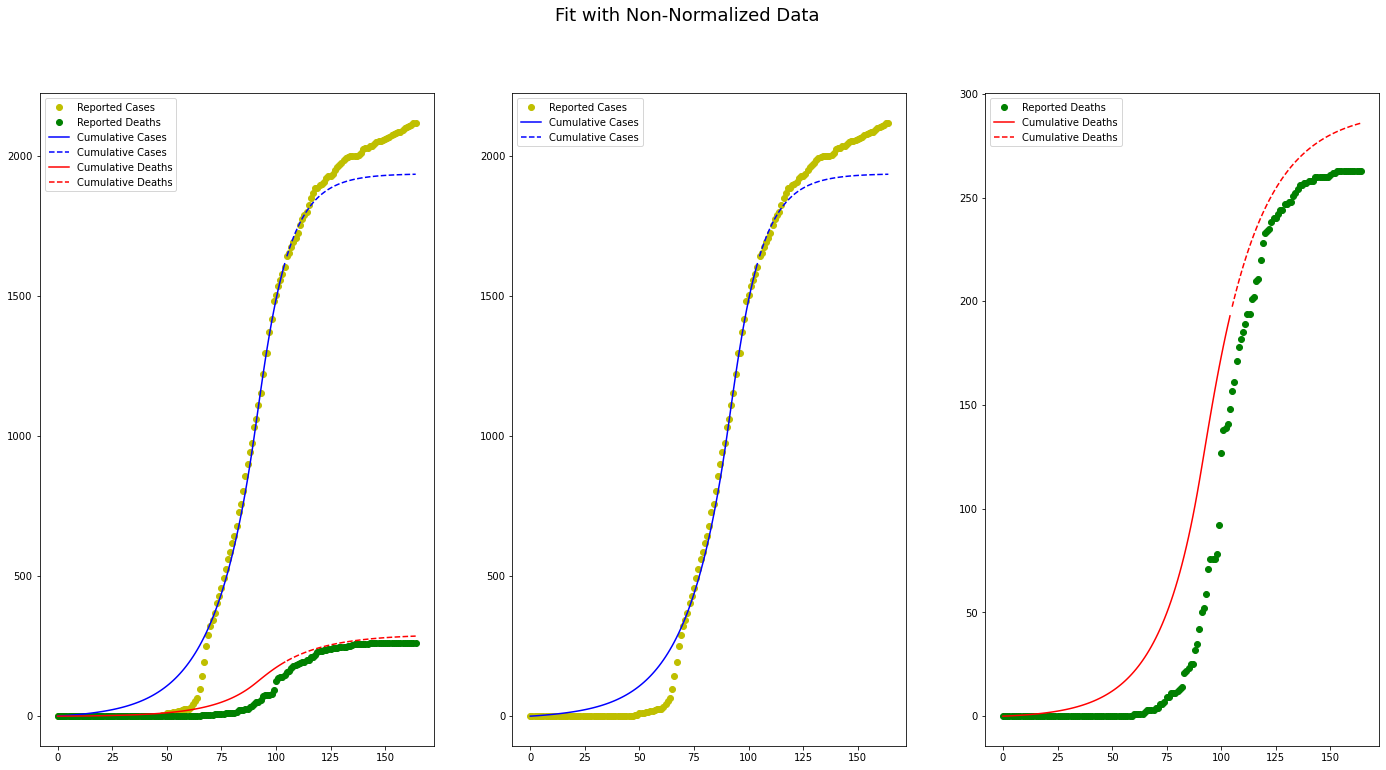

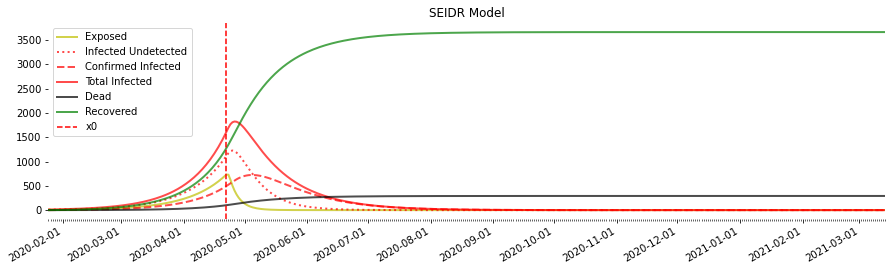

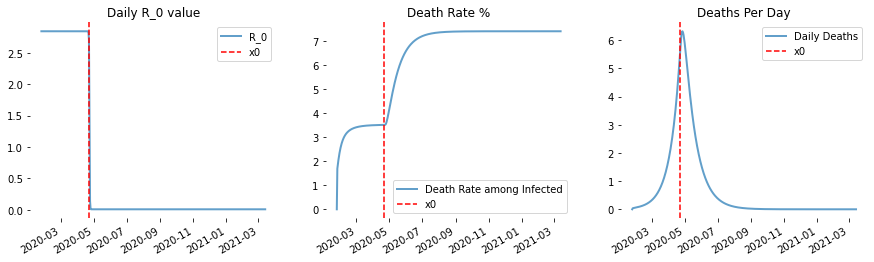

Interested in HR: 3551 City of Ottawa Health Unit
According to the model, the total number of confirmed cases is 1937.0, compared to 2118 as reported in the covid data
The model estimates that there are a total of 3943.0 infections.

True deaths: 263
Predicted deaths: 291.69444141072836
Thus, the risk level in health region 3551 is decreasing compared to 60 days ago


In [21]:
# View a particular fit result
hr = hr_list[0] # The HR to view
num = 1 # Fits are ranked by their Reduced chi-squared error. This selects the num-th value in the ranking.
days_back = days_list[0] # Select which prediction you want

params =  get_best_fits(file_prefix + str(days_back) + '_days_' + str(hr) + file_suffix, num)[num - 1][1:]
print(params)

plot_fit(hr, params, None, days_back)
N, x_dat, cases, deaths, rep_dates = get_some_data(hr)
days = len(rep_dates)
delta = params[6]

model_1 = Model(days + 250, N, *params)
t, S, E, IU, CI, D, R, R_0_over_time, beta_over_time = model_1

plotting(*model_1, x_ticks = rep_dates, x0 = params[2])
predict_risk(hr, [days, N] + params, model_1, days_back)

In [22]:
# View all the predictions at once
hr = hr_list[0]


N, x_dat, cases, deaths, rep_dates = get_some_data(hr)
x = np.linspace(0, len(deaths) - 1, len(deaths))
fig,ax = plt.subplots(figsize = (12,8))

predict_dict = {}

for days in days_list:
        predict_dict[days] = get_best_fits(file_prefix + str(days) + '_days_' + str(hr) + file_suffix, 1)[0][1:]
    

ax.scatter(x, deaths, alpha = 0.25, color = 'k', label = "Reported Deaths")

for days_b, res in predict_dict.items():
    if days_b == None:
        continue
    R_0_start, k, x0, R_0_end, tau1, tau2, delta, epsilon, rho, gamma, alpha = res
    days = len(x_dat)
    eva = fitter(x_dat, days + days_b, N, R_0_start, k, x0, R_0_end, tau1, tau2, delta, epsilon, rho, gamma, alpha)
    half = int(len(eva) / 2)
    eva1 = eva[:half]
    eva2 = eva[half:]

    line, = ax.plot(x[:-days_b], eva2[:-days_b], "-", label = f"Fit forgetting {days_b} days")
    ax.plot(x[-days_b:], eva2[-days_b:], '--', color = line.get_color(), label = f"Prediction from {days_b} days ago")

ax.legend()
ax.set_title(f"Retrospective Predictions for Deaths in HR {hr}")

Text(0.5, 1.0, 'Retrospective Predictions for Deaths in HR 3551')

In [23]:
# Get the results by the numbers
hr = hr_list[0]

N, x_dat, cases, deaths, rep_dates = get_some_data(hr)
print()
for days_b, res in predict_dict.items():
    if days_b == None:
        continue
    R_0_start, k, x0, R_0_end, tau1, tau2, delta, epsilon, rho, gamma, alpha = res
    days = len(x_dat)
    eva = fitter(x_dat, days + days_b, N, R_0_start, k, x0, R_0_end, tau1, tau2, delta, epsilon, rho, gamma, alpha)
    half = int(len(eva) / 2)
    eva1 = eva[:half]
    eva2 = eva[half:]
    
    print(f'{days_b} days ago, we predicted {int(np.ceil(eva1[-1]))} cases and {int(np.ceil(eva2[-1]))} deaths today')
print(f'\n    In reality, there are {cases[-1]} cases and {deaths[-1]} deaths today')


print()


60 days ago, we predicted 1936 cases and 286 deaths today
30 days ago, we predicted 2064 cases and 240 deaths today
14 days ago, we predicted 2076 cases and 260 deaths today

    In reality, there are 2118 cases and 263 deaths today



Text(0.5, 1.0, 'Parameters in the best 10 fits')

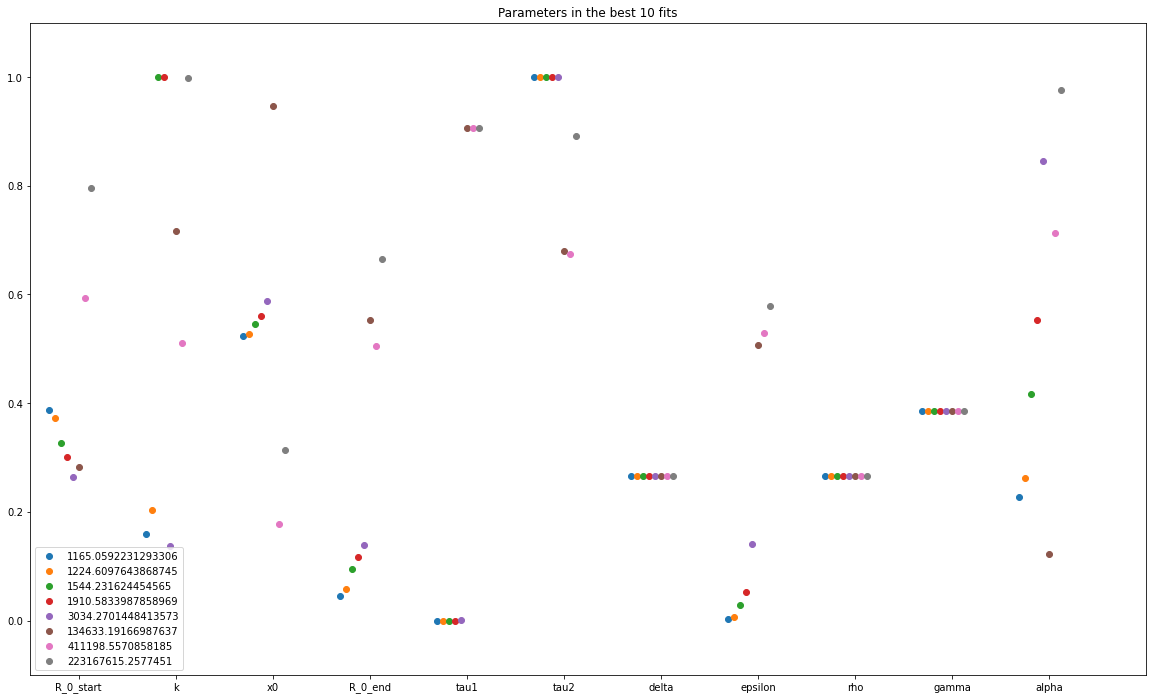

In [24]:
# View the parameters for the best fits
# On the x-axis, we have all the parameters. Dots are labeled by their reduced chi-squared score. 
# All parameters are normalized between 0 and 1, which correspond to the max and min values that we have set in the param_dicts
hr = hr_list[0]
days_b = days_list[3]
num_best = 10 # The number of parameter sets to plot
file_name = file_prefix + str(days_b) + "_days_" + str(hr) + file_suffix




fig, ax = plt.subplots(figsize = (20,12))

offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

columns = ['red_chi_sqd','R_0_start','k','x0','R_0_end','tau1','tau2','delta','epsilon','rho','gamma','alpha']

good_rows = get_best_fits(file_name, num_best)

for num, row in enumerate(good_rows):
    ax.scatter(columns[1:], [rescale(float(val), param_dict[columns[param_num + 1]][2], param_dict[columns[param_num + 1]][3], 0 ,1 ) for param_num, val in enumerate(row[1:])], transform = trans + offset(num * 6 - 3 * num_best), label = str(row[0]))
    

ax.set_ylim(-0.1,1.1)
ax.set_xlim(-0.5, 11)
ax.legend()
ax.set_title(f'Parameters in the best {num_best} fits')

### Other things we tried;

Along the way, we also implemented the following, however due to different reasons they didn't make it into this final version;
- fitting to rolling averages of data; Implementing a $n$-day rolling average to the cases and deaths data gave good looking results. This is done in `SeparateInfected.ipynb`. It was not included in the final model because it was unclear if it was actually improving the fits or if they just looked better, superficially. 
- a multilogistic model for $R_0$. This is a logistic function that has two changes. This has been implemented in `doubleBumpLogistic.ipynb`. This was a way to model the fact that cases were increasing after we started reopening. This was abandoned after it was realized that two bumps are unstable; if the end value for `R_0` ended up $ > 1$, then the model would show the pandemic sweeping the population and infecting everyone. So we would need at least a triple-bump $R_0$, however we don't have the data at this time to model when the pandemic starts to slow down again, so we are stuck for now.
- fitting the epi_dict with latin hypercubes as well. This has been implemented in `latinHypercubes.ipynb`, I think. Who knows.
- refitting based on best values. This has been implemented in `latinHypercubes.ipynb`. Here, we take the best parameter fits and put them back into the fitting algorithm. However, the results after the second fit tend to be worse, so we didn't continue with this.

# Explanation

# Fitting all parameters to cases and deaths data
## Introduction
In this file, we review the compartmental model improved by being allowed to fit to all parameters as well as having access to cases and deaths data.

We fit to the 'cumulative_cases' and 'cumulative_deaths' columns of the Covid19 table. 

The following is the model that we are fitting:
\begin{align}
\frac{dS}{dt} &= - \frac{S[\tau_1 IU + \tau_2 CI]\beta(t)}{N} \\
\frac{dE}{dt} &= \frac{S[\tau_1 IU + \tau_2 CI]\beta(t)}{N} - \delta E \\
\frac{dIU}{dt} &= \delta E - \varepsilon IU - \rho \alpha IU - \gamma (1 - \alpha) IU \\
\frac{dCI}{dt} &= \varepsilon IU - \rho \alpha CI - \gamma (1 - \alpha) CI \\
\frac{dD}{dt} &= \rho \alpha (IU + CI) \\
\frac{dR}{dt} &= \gamma (1 - \alpha) (IU + CI) 
\end{align}
where
- beta $\beta$: rate of transmission.
- tau $\tau_i$: "mixing coefficient" of each infected compartment with the susceptible population
- delta $\delta$: 1 / incubation period
- epsilon $\varepsilon$: proportion of infected people who get tested. We assume that everyone who is tested is tested positive, and that only infected people are tested.
- rho $\rho$: 1 / time it takes to go from infection to death
- alpha $\alpha$: rate of infected people who die
- gamma $\gamma$: 1 / time it takes to go from infection to recovered

and S,E,IU,CI,D,R are Susceptible, Exposed, Infected Undetected, Confirmed Infected, Deceased, and Recovered compartments. We fit the 'cumulative_cases' to Confirmed Infected, and 'cumulative_deaths' to Deceased.

We model $\beta$ using the reproductive number $R_0$ using the formula $R_0 = \frac{\beta}{\gamma}$. We assume that the region implements social distancing and other virus-suppressing methods, and as such $R_0$ drops at some point during the pandemic, modeled by a logistic curve. That is, we model $R_0$ using the formula
$$R_0(t) = \frac{R_0^s - R_0^e}{1 + \exp(- k (t + x_0))} + R_0^e,$$
where:
- R_0_start $R_0^s$: the value before the logistic switch
- R_0_end $R_0^e$: the value after the logistic switch
- k $k$: how rapidly the switch occurs, higher is faster
- x0 $x_0$: when the switch occurs; the switch is centred around this value

Benefits of modeling $R_0$ in this way is that we can account for the fact that virus prevalence has sharply decreased in the past months; drawbacks of it is that it can only model a single change, so if we take a sharp increase in cases at some point we will have to alter the model. 

In [ ]:
def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start - R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

x_exp = np.linspace(-5,10,1000)
y_exp = [logistic_R_0(x_val, R_0_start = 5, k = 6, x0 = 3, R_0_end = 2) for x_val in x_exp]
plt.plot(x_exp, y_exp)
plt.title("$R_0$ Modeled as a Logistic Function")
plt.axvline(x = 3, color = 'r', linestyle = '--')
plt.text(-4, 2.5, 'the red dotted line\nis when the NPI start\nto slow the spread')
plt.show()

## Data
Let's take a look at the data available to us. We fit the model based on cumulative numbers for cases and deaths (this data comes from the *COVID-19 Canada Open Data Working Group*), and we have access to some general information about the HR's (From the *Open Database of Healthcare Facilities*).

Sources: 
- Covid: https://github.com/ishaberry/Covid19Canada
- ODHF: https://www.statcan.gc.ca/eng/lode/databases/odhf

In [ ]:
plot_frame(get_HR_data('report_date, cumulative_cases, cumulative_deaths', 3551), hr_name = 'Ottawa')
get_HR_dict(3551)

## The model
We've already shown the differential equations we are modeling in this compartmental SEIDR model. We code these into the `deriv` function, which takes the epidemiological parameters and returns the differentials of each compartment. We also have the `Model` function, which takes all of the parameters and returns the size of the compartments on each day. We also have a `plotting` function. To use the `lmfit` package, we need a `fitter` function, which evaluates the model at each time step and returns the values that we are modeling so that `lmfit` can compute the residuals (by calculating the difference between these values and the input data).

The fitting function as well as any SEIDR model is very sensitive to initial conditions, and in the optimization process there are a lot of local minima which we don't want to get stuck in. So, we use Latin Hypercube sampling (LHC) to set the initial conditions for the fit for some of the parameters. These are in the `vary_dict`. This way, we can try to avoid the local minima. 

# Prediction process

Suppose $x_1, \dots, x_T$ are the actual cases and deaths data for a particular HR, where $T$ is today. We would like some way to measure whether this HR is at high- or low- risk, as of today.

We have a compartmental model that we can fit to our cases data. Once fitted, we get guesses for the epiparameters and we can extrapolate the model as far forward as we would like. Suppose the model outputs $y_1, \dots, y_N$ for any value of N we choose. 

## Idea: ad-hoc retrospection

Good modelers should always return to their old models and evaluate how well they predicted reality. By restricting the data that we provide to the modeling function, we can make a model as if it was fitted several days ago, and compare how it predicts today should look to how today actually looks.

Method: Given $T$ days of data, fit to the first $T - d$ days, for some $d$. Use the resulting model to predict the number of deaths we'd expect today $y_T$, and compare it to the actual number of deaths $x_T$. 
- If $y_T > x_T$, then there were less deaths than we expected a $d$ days ago. Predict low-risk
- If $y_T < x_T$, then there are more deaths than we expected $d$ days ago. Predict high-risk.

It is important to note that this method only characterizes the *relative* risk level; that is, when we predict low-risk, what we really mean is that the risk is lower in this particular HR than it was before.